#### Context
Any given Minecraft world has a seed that is used to generate the world. That seed determines all randomness, including what biome you spawn in. While playing the game, it feels like it is disproportionately likely to spawn close to an ocean (for the purposes of this project, within a 256 block radius). This project aims to determine if this is true, and if so, how much more likely it is to spawn near an ocean than in any other biome.  

In [ ]:
# Imports
!pip install preliz

import preliz as pz
import numpy as np
import arviz as az
import pymc as pm

#### Prior
In Minecraft, the "continentalness" of the spawn point must be between -0.11 and 1.0, where anything <-0.19 is an ocean. Therefore, it should be more likely to spawn much further inland than near an ocean. Furthermore, given that you can spawn within some arid biomes, which are less likely to be near an ocean, it should be more likely than not that there is no ocean nearby. Therefore, I believe that the chance of spawning near an ocean is about 40% (2 in 5). Due to the uncertainty in this prior belief, I will use a rather wide beta distribution, with a low alpha and beta (4 and 6, respectively).

Mean:   40.00%

Median: 39.31%

<Axes: >

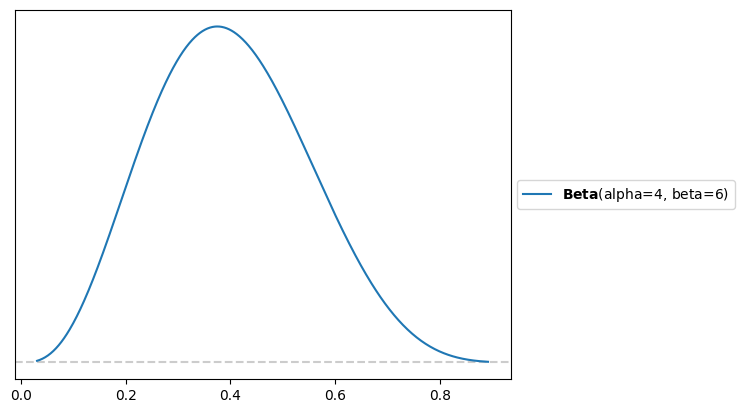

In [35]:
# Prior
pz.Beta(alpha=4, beta=6).plot_pdf()

#### Data
In order to determine the likelihood of spawning near an ocean, I need data on a large number of seeds. To that end, I modified the Minecraft source code such that it generated 10,000 random seeds. It used the same process as the game to determine the biome map (which is based on the combination of 5 octaves of Perlin noise), and then checked if the player would spawn within 256 blocks of an ocean.

Much to my shock, of the 10,000 seeds, **6761** resulted in a spawn near an ocean. Plotting this using a binomial distribution, we get the following likelihood:

<Axes: >

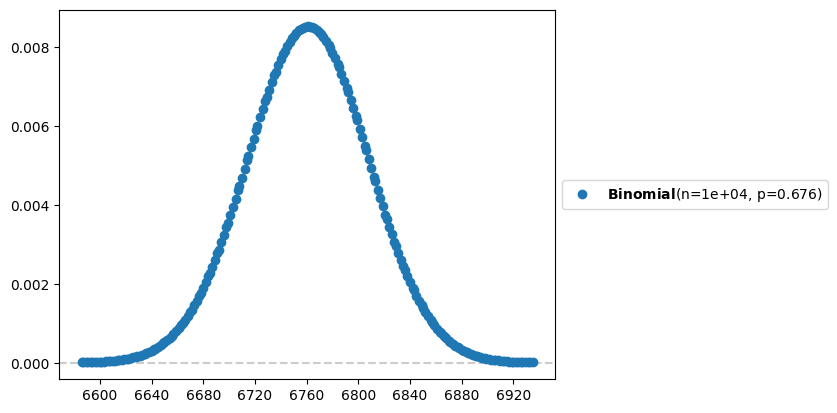

In [36]:
# Likelihood
pz.Binomial(n=10000, p=6761/10000).plot_pdf()

#### Posterior
Given the prior and likelihood, we can calculate the posterior distribution. For this, I will once again use the Beta distribution. As you can see, the posterior is much more peaked than the prior, with both a mean and median of 67.58%. As one can tell from the plot, the large sample size makes for a very narrow distribution, only spanning ~3%.

<Axes: >

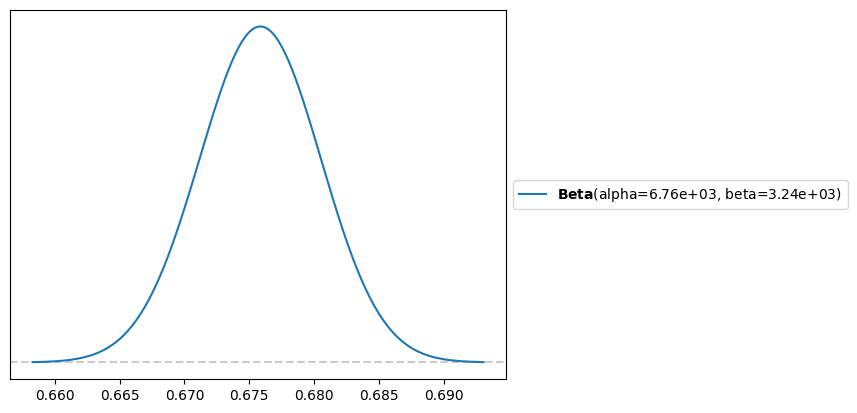

In [37]:
# Posterior
pz.Beta(alpha=4+6761, beta=6+10000-6761).plot_pdf()

#### Model
Finally, it is time to build the MCMC model using PyMC. I will use the same prior and likelihood as before, then plot a sample of 1,000. We can once again see that the large amount of collected data leads to a very precise posterior, mirroring the analytical plot.  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'p'}>

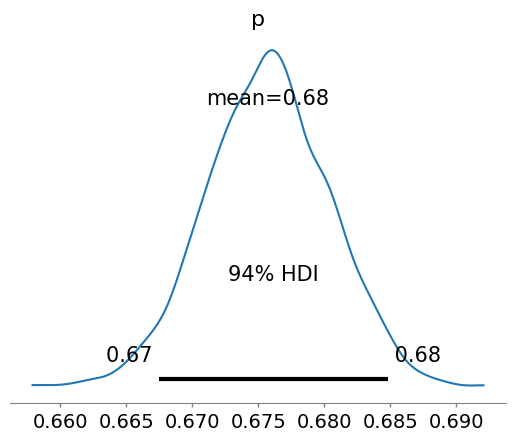

In [38]:
# Model
data = np.repeat([1, 0], [6761, 10000-6761])

with pm.Model() as model:
    p = pm.Beta('p', alpha=4, beta=6)
    y = pm.Bernoulli('y', p, observed=data)
    
    post = pm.sample(1000)

az.plot_posterior(post)

#### Predictive Posterior
Finally, it's time to make some predictions. We will sample the posterior predictive, then extract the prediction for the next 10,000 seeds. Again, we have a very precise posterior, so the prediction should be very close to the collected data.

In [39]:
# Predictive Posterior
pm.sample_posterior_predictive(post, model=model, extend_inferencedata=True)

vals = az.extract(post, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series().values

print(f"Near an ocean: {np.sum(vals)}/10000")

Sampling: [y]


Output()

Near an ocean: 6672/10000


#### Conclusion
Once again, the data has proven my prior belief to be very incorrect. Going with the mean of ~67.5%, the chance of spawning near an ocean isn't even close to the ~40% I predicted. However, it is still possible given the prior. Looking at the plot, 0.6 is well within possibility. Finally, since the data is based on a random seed, and had a large enough sample size, this result should be very indicative of the true percentage.